<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/Test_of_full_TCN_QTDB%2BLUDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/
#or
!mkdir '/content/physionet.org'
!mkdir '/content/physionet.org/files'
!mkdir '/content/physionet.org/files/edb'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/edb' '/content/physionet.org/files/'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/' '/content/physionet.org/files/ecgiddb/'

In [2]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 91.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [3]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [9]:
from keras.saving import load_model
from tensorflow.keras.utils import register_keras_serializable
@register_keras_serializable()
def weighted_binary_crossentropy(y_true, y_pred):
    weight = tf.reduce_mean(y_true) * 0.5 + 0.5
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(loss * weight)

model = load_model("/content/drive/MyDrive/Final project/QRS detection/TCN/first_QRS_T_P.keras", custom_objects={
    'weighted_binary_crossentropy': weighted_binary_crossentropy
})


# functions

In [4]:
def bandpass_filter(signal, lowcut=0.5, highcut=10, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)

In [5]:

from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    """
    Rescales annotation sample indices from original_fs to target_fs.
    Works with scalars or lists/arrays.
    """
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)



In [6]:
def create_multi_class_mask(length, wave_regions):
    mask = np.zeros((length, 3))  # [P, QRS, T]
    label_map = {'p': 0, 'N': 1, 't': 2}
    for label, regions in wave_regions.items():
        for start, end in regions:
            mask[start:end, label_map[label]] = 1
    return mask


In [7]:
def segment_signal_and_mask(signal, mask, window_size, fs):
    segments = []
    masks = []
    for i in range(0, len(signal) - window_size, window_size // 5):  # 2% overlap
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        segments.append(segment)
        masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [8]:
from scipy.ndimage import median_filter, label
import numpy as np

def post_process_predictions(predictions, threshold=0.5, min_duration=20):
    """
    Apply post-processing to all predicted segments.

    predictions: np.array of shape (num_segments, segment_length, 3)
    threshold: float, classification threshold
    min_duration: int, minimum valid blob length in samples
    """
    num_segments, segment_len, num_classes = predictions.shape
    cleaned = np.zeros_like(predictions)

    for seg in range(num_segments):
        for cls in range(num_classes):
            # Threshold
            binary_mask = predictions[seg, :, cls] > threshold

            # Median filter to remove flickers
            smoothed = median_filter(binary_mask.astype(int), size=7)

            # Remove short blobs
            labeled_array, num_features = label(smoothed)
            for i in range(1, num_features + 1):
                blob = (labeled_array == i)
                if blob.sum() >= min_duration:
                    cleaned[seg, :, cls][blob] = 1
    return cleaned


# ecgiddb Person_84/rec_2

In [17]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_84/rec_2')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)


(5000,)


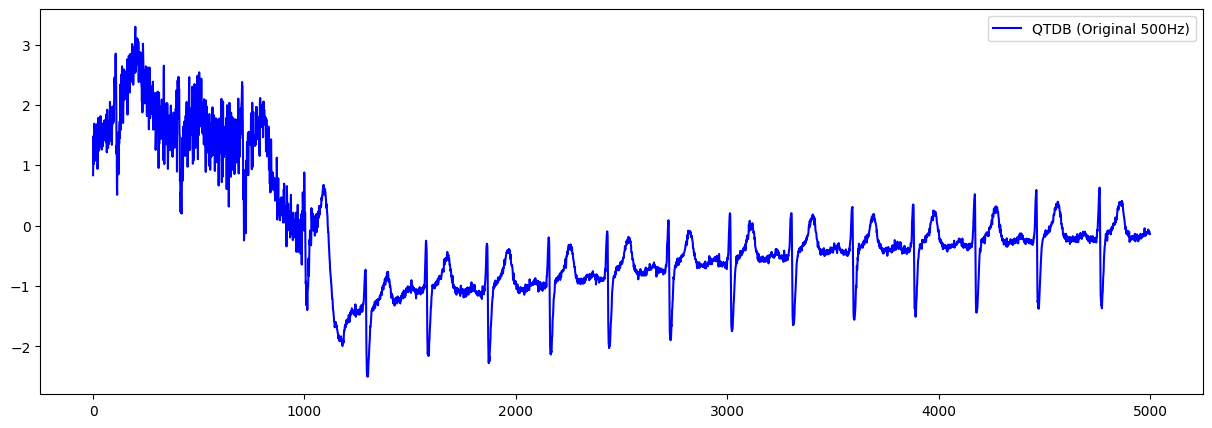

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(first_10_seconds, label=f"QTDB (Original {new_fs}Hz)", color='blue')
plt.legend()
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds,fs=new_fs)))
first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size , 250)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


In [20]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.1).astype(int)  # Convert probabilities to binary masks
#print(y_pred[y_pred > 0])  # P


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[[[7.18858540e-02 8.68432894e-02 9.21085328e-02]
  [1.48371188e-02 5.40721178e-01 1.28552690e-01]
  [2.27589849e-02 4.65195805e-01 3.37622195e-01]
  ...
  [7.70089477e-02 6.30048066e-02 2.30880857e-01]
  [1.48064703e-01 6.05589263e-02 2.17234924e-01]
  [2.08574340e-01 4.33233008e-02 2.06790924e-01]]

 [[6.26016110e-02 3.15894634e-01 5.56492805e-01]
  [1.16958864e-01 8.35194290e-02 6.44462049e-01]
  [1.46548137e-01 5.55356927e-02 7.61639893e-01]
  ...
  [2.23753578e-03 9.67371225e-01 4.45430196e-05]
  [1.29923748e-03 9.82278466e-01 6.07951879e-05]
  [1.08805578e-03 9.85854447e-01 9.31356335e-05]]

 [[2.14539424e-01 1.26968861e-01 2.93648839e-01]
  [2.79902488e-01 4.38589416e-02 3.36615324e-01]
  [2.67138630e-01 1.92513876e-02 2.67140061e-01]
  ...
  [9.81766641e-01 4.93177585e-02 1.07606193e-05]
  [9.82526958e-01 3.43023427e-02 1.36024373e-05]
  [9.74480748e-01 1.91298611e-02 1.56679434e-05]]

 ...

 [[1.07157521e-01 8.49427506e-02 1.08785935e-01]
 

In [21]:
# Example:
y_pred_clean = post_process_predictions(y_pred, threshold=0.5, min_duration=int(0.03 * new_fs))  # ~30ms


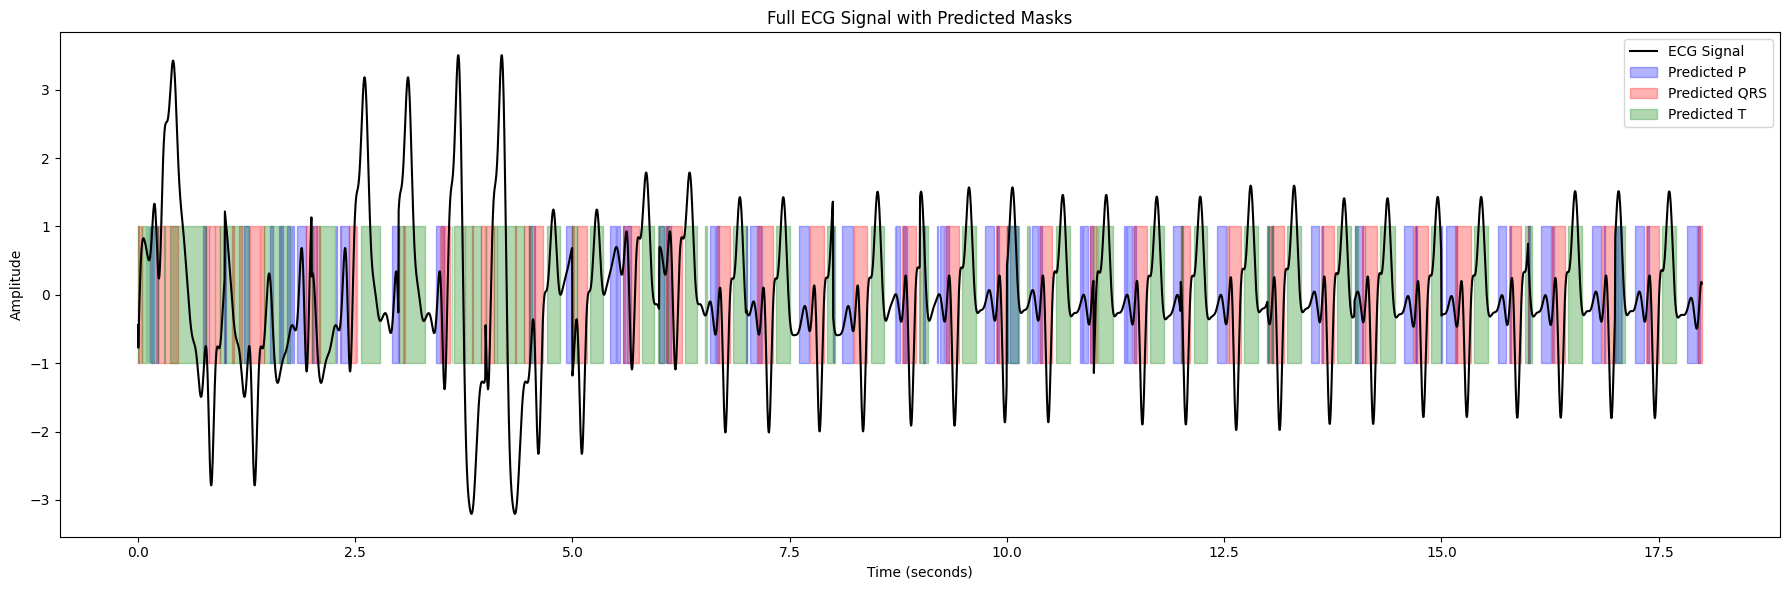

In [22]:
import matplotlib.pyplot as plt

full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

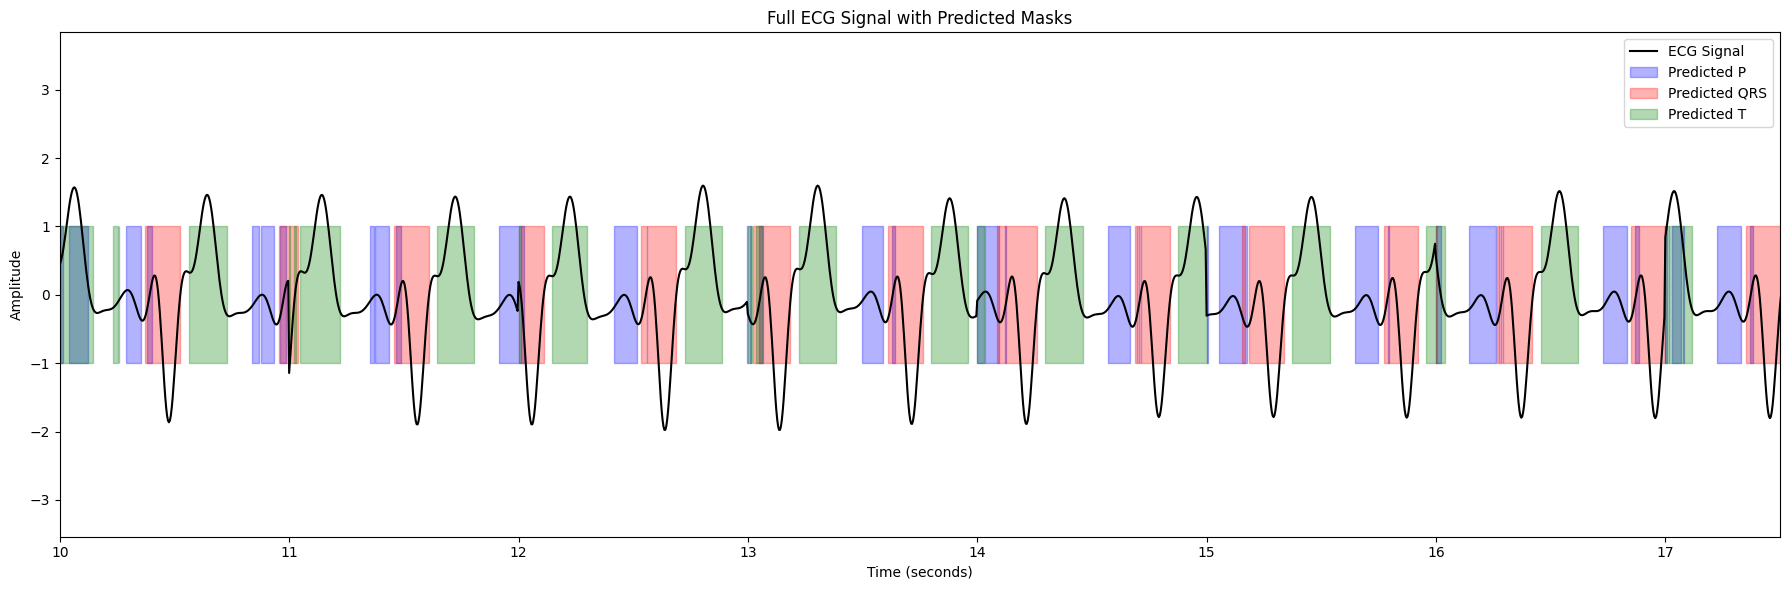

In [23]:
full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.xlim(10, 17.5)  # Zoom into 5s to 7s
plt.show()

# ecgiddb Person_48/rec_1

In [24]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)


(5000,)


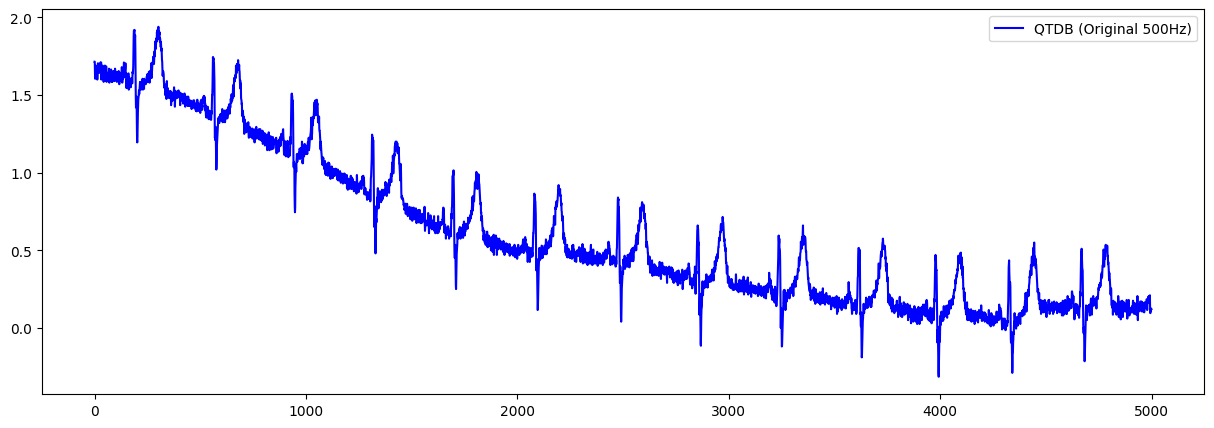

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(first_10_seconds, label=f"QTDB (Original {new_fs}Hz)", color='blue')
plt.legend()
plt.show()

In [26]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds,fs=new_fs)))
first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size , 250)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


In [27]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.1).astype(int)  # Convert probabilities to binary masks
#print(y_pred[y_pred > 0])  # P


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
[[[2.03651622e-01 8.79028738e-02 2.53620297e-01]
  [2.13480607e-01 4.37922999e-02 2.19991297e-01]
  [2.83914179e-01 3.20796445e-02 3.54342908e-01]
  ...
  [9.45404053e-01 3.22421984e-05 2.31737460e-04]
  [9.62338805e-01 3.18707098e-05 1.59143761e-04]
  [9.62687969e-01 3.81298596e-05 1.47167710e-04]]

 [[1.70423612e-01 5.02752289e-02 1.83482975e-01]
  [1.85627863e-01 3.84133495e-02 1.83570817e-01]
  [2.01590583e-01 1.82963945e-02 1.55349478e-01]
  ...
  [1.77195005e-04 5.55429899e-04 1.89690199e-03]
  [7.55416186e-05 3.72071489e-04 1.63577741e-03]
  [4.17294432e-05 2.70635501e-04 1.86708954e-03]]

 [[1.19898044e-01 8.71525034e-02 1.29666701e-01]
  [1.21737443e-01 7.19608143e-02 1.84152737e-01]
  [3.38248074e-01 3.93993668e-02 2.13199049e-01]
  ...
  [9.75054377e-07 2.98306084e-04 7.95864558e-04]
  [1.33987612e-06 1.82278629e-04 1.91472145e-03]
  [1.88722731e-06 3.68153298e-04 6.72953296e-03]]

 ...

 [[4.10840176e-02 3.85541826e-01 5.85244000e-01]


In [28]:
# Example:
y_pred_clean = post_process_predictions(y_pred, threshold=0.5, min_duration=int(0.03 * new_fs))  # ~30ms


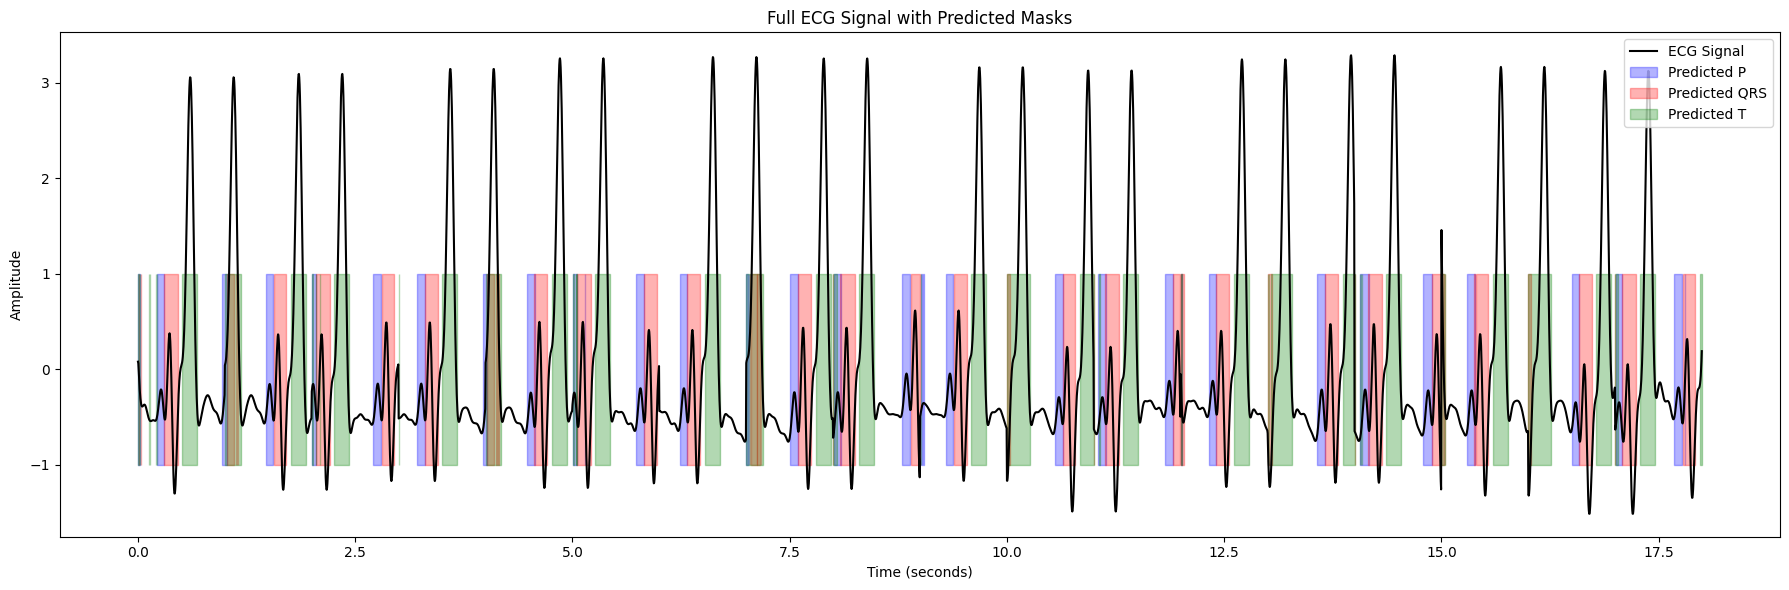

In [29]:
import matplotlib.pyplot as plt

full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

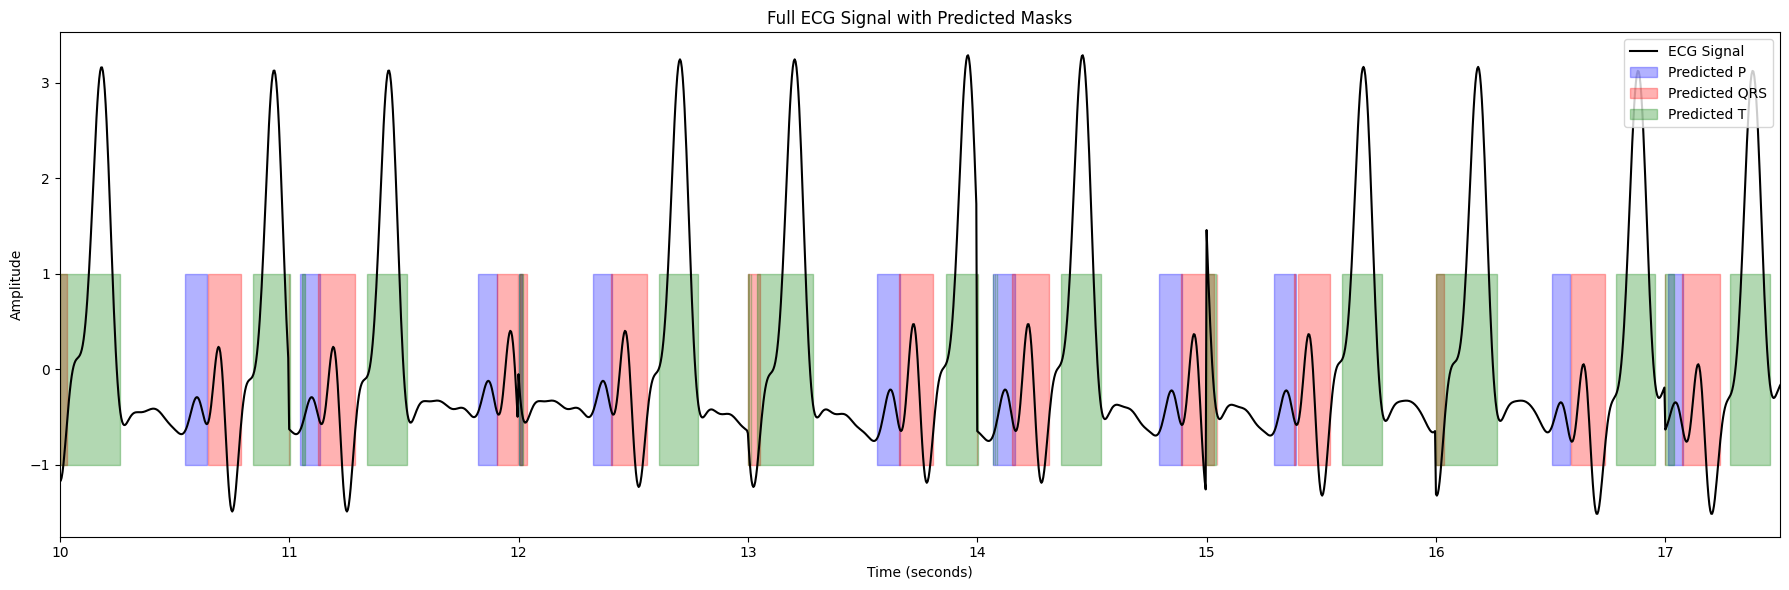

In [30]:
full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.xlim(10, 17.5)  # Zoom into 5s to 7s
plt.show()

# ecgiddb Person_02/rec_1

In [10]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_02/rec_1')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)


(5000,)


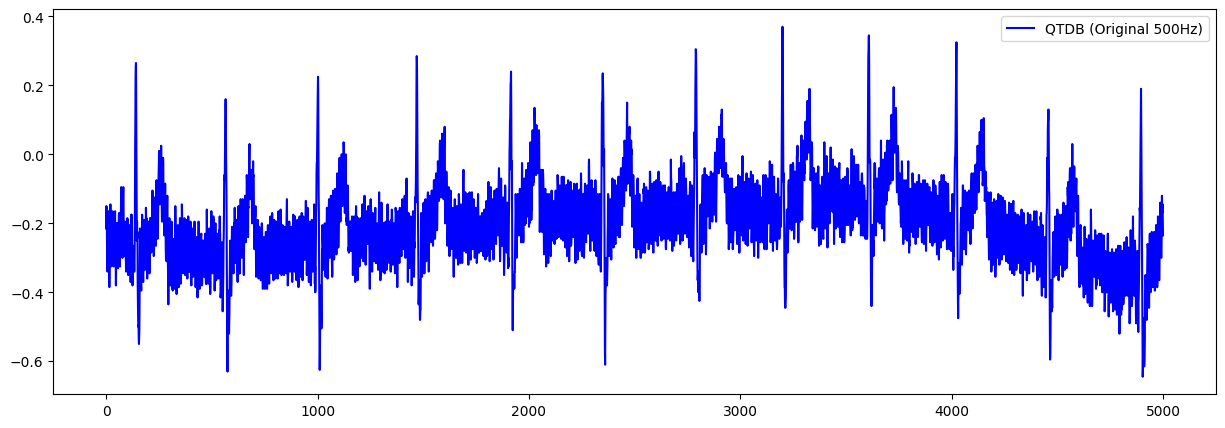

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(first_10_seconds, label=f"QTDB (Original {new_fs}Hz)", color='blue')
plt.legend()
plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds,fs=new_fs)))
first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size , 250)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


In [13]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.1).astype(int)  # Convert probabilities to binary masks
#print(y_pred[y_pred > 0])  # P


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[[1.49255857e-01 6.43844530e-02 1.78910851e-01]
  [1.15809046e-01 8.03060010e-02 1.18430547e-01]
  [2.31818512e-01 1.03236683e-01 1.85597360e-01]
  ...
  [9.97002900e-01 3.38473095e-04 3.87175387e-04]
  [9.98134851e-01 3.37494508e-04 2.35099054e-04]
  [9.97406065e-01 3.97501950e-04 8.16472166e-05]]

 [[2.49912892e-03 7.68336236e-01 2.79875815e-01]
  [8.22375761e-04 5.45892596e-01 6.31309569e-01]
  [1.82448793e-03 5.05072117e-01 5.03261983e-01]
  ...
  [1.16188276e-05 8.03898820e-06 5.74586727e-03]
  [8.79031268e-06 4.28446401e-06 3.28132161e-03]
  [7.20432217e-06 3.63534400e-06 3.10876337e-03]]

 [[2.18962833e-01 1.22894362e-01 2.80238390e-01]
  [2.43925452e-01 5.79735599e-02 2.78181165e-01]
  [1.50588855e-01 1.50100440e-02 1.45556897e-01]
  ...
  [1.23827440e-05 9.90798593e-01 8.91675791e-06]
  [4.31572471e-06 9.93001878e-01 1.00853413e-05]
  [4.40350186e-06 9.95667577e-01 1.18974986e-05]]

 ...

 [[9.42288637e-02 2.59586275e-01 5.11424720e-01]
  [

In [14]:
# Example:
y_pred_clean = post_process_predictions(y_pred, threshold=0.5, min_duration=int(0.03 * new_fs))  # ~30ms


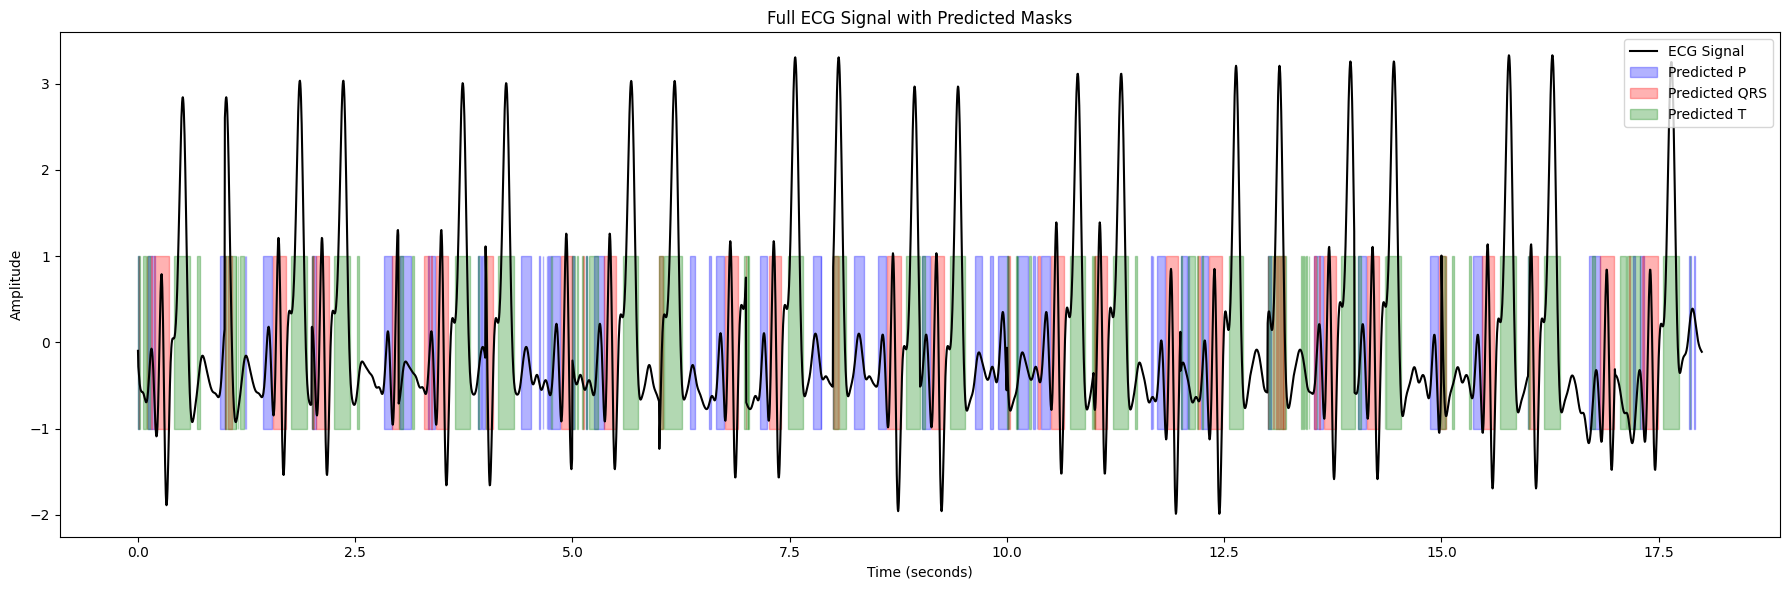

In [15]:
import matplotlib.pyplot as plt

full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

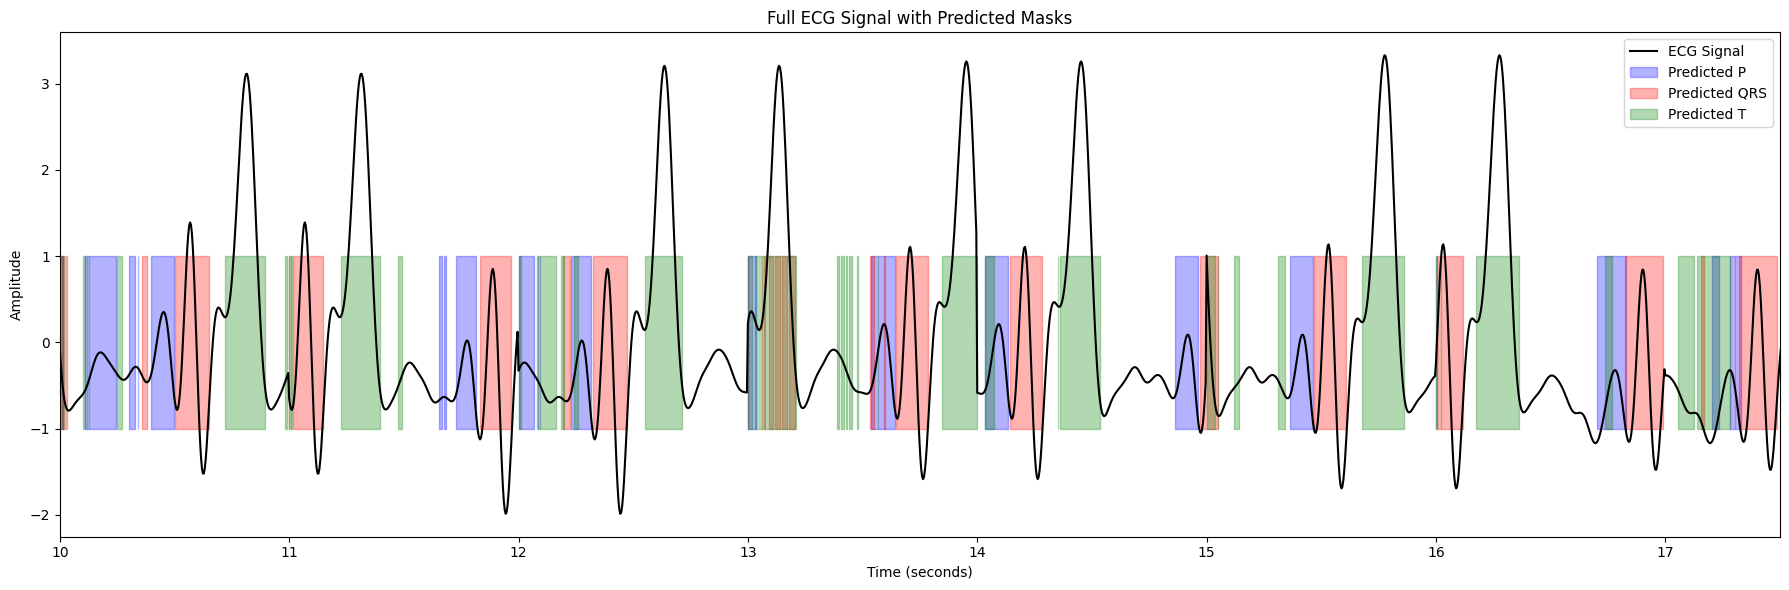

In [16]:
full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.xlim(10, 17.5)  # Zoom into 5s to 7s
plt.show()

# edb e0601

In [31]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/edb/1.0.0/e0601')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)


(2500,)


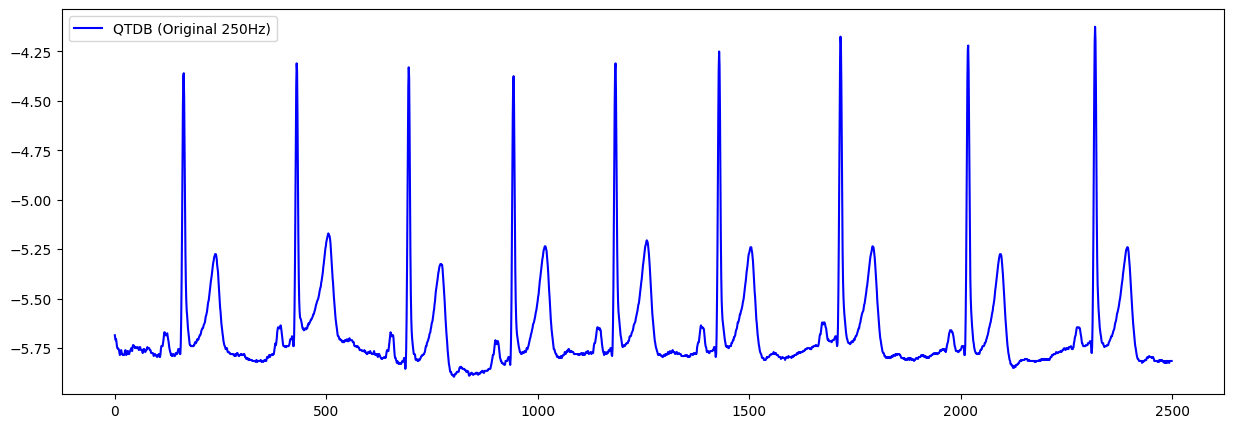

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(first_10_seconds, label=f"QTDB (Original {new_fs}Hz)", color='blue')
plt.legend()
plt.show()

In [33]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds,fs=new_fs)))
first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size , 250)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


In [34]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.1).astype(int)  # Convert probabilities to binary masks
#print(y_pred[y_pred > 0])  # P


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
[[[1.45460814e-01 6.69432431e-02 1.73299700e-01]
  [1.23087265e-01 6.19947501e-02 1.67022407e-01]
  [2.42397681e-01 8.25449005e-02 2.56987751e-01]
  ...
  [1.42082965e-04 2.49018626e-06 9.98173833e-01]
  [1.37930823e-04 2.46113723e-06 9.98727143e-01]
  [1.20357086e-04 2.09801601e-06 9.99278843e-01]]

 [[1.52438566e-01 5.85108697e-02 1.90242887e-01]
  [1.38042763e-01 5.26244454e-02 2.01214492e-01]
  [1.10873252e-01 1.80129539e-02 1.56852663e-01]
  ...
  [1.79008156e-01 3.97045573e-04 3.58379562e-04]
  [3.03521335e-01 3.63012718e-04 3.41425242e-04]
  [4.79738235e-01 3.37378384e-04 3.01822787e-04]]

 [[1.84106335e-01 1.46327138e-01 3.95523071e-01]
  [1.55727834e-01 1.54165879e-01 4.50380027e-01]
  [2.17492148e-01 1.07783355e-01 6.64307892e-01]
  ...
  [6.72231408e-06 1.95274115e-05 9.97617006e-01]
  [9.69019948e-06 2.67433843e-05 9.97401953e-01]
  [9.23624248e-06 2.91133001e-05 9.97898698e-01]]

 ...

 [[2.58882493e-02 1.11392155e-01 1.45405397e-01]


In [35]:
# Example:
y_pred_clean = post_process_predictions(y_pred, threshold=0.5, min_duration=int(0.03 * new_fs))  # ~30ms


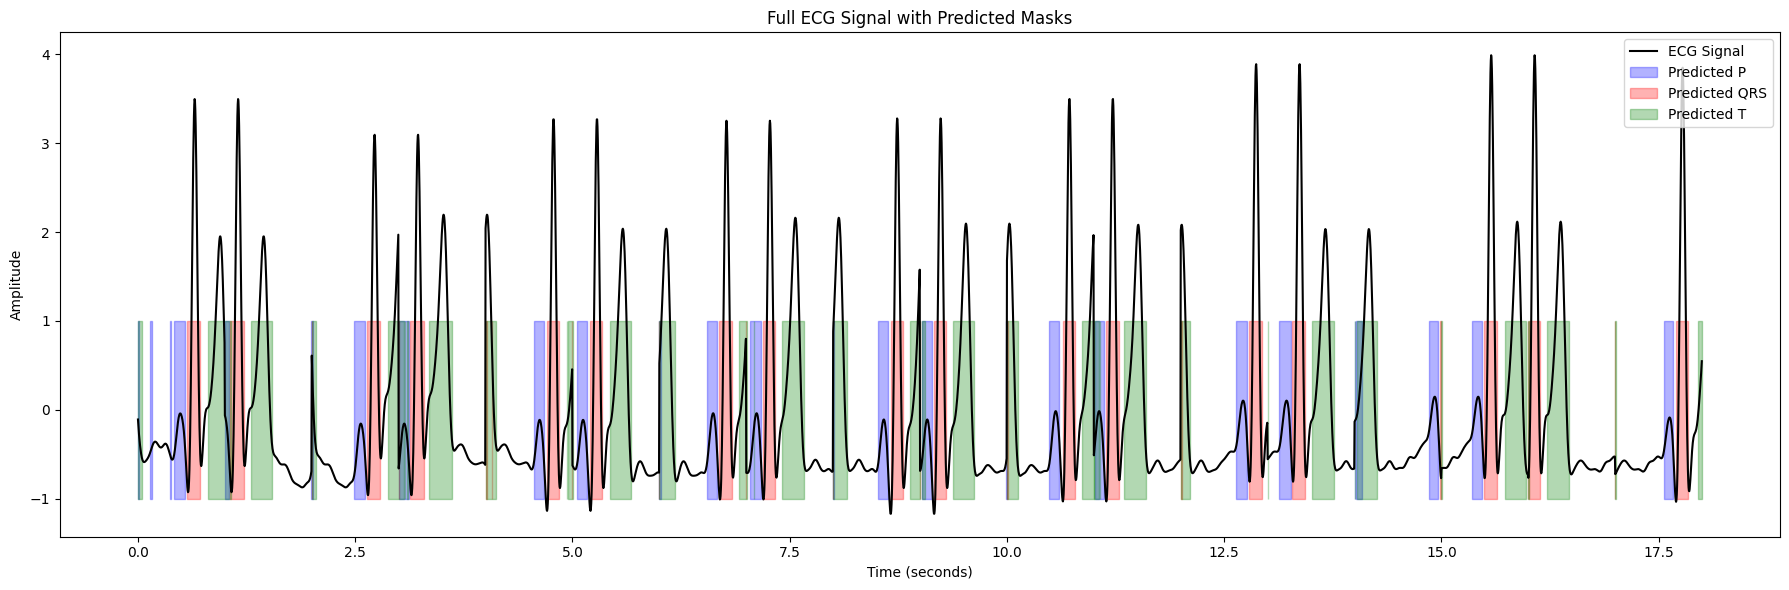

In [36]:
import matplotlib.pyplot as plt

full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

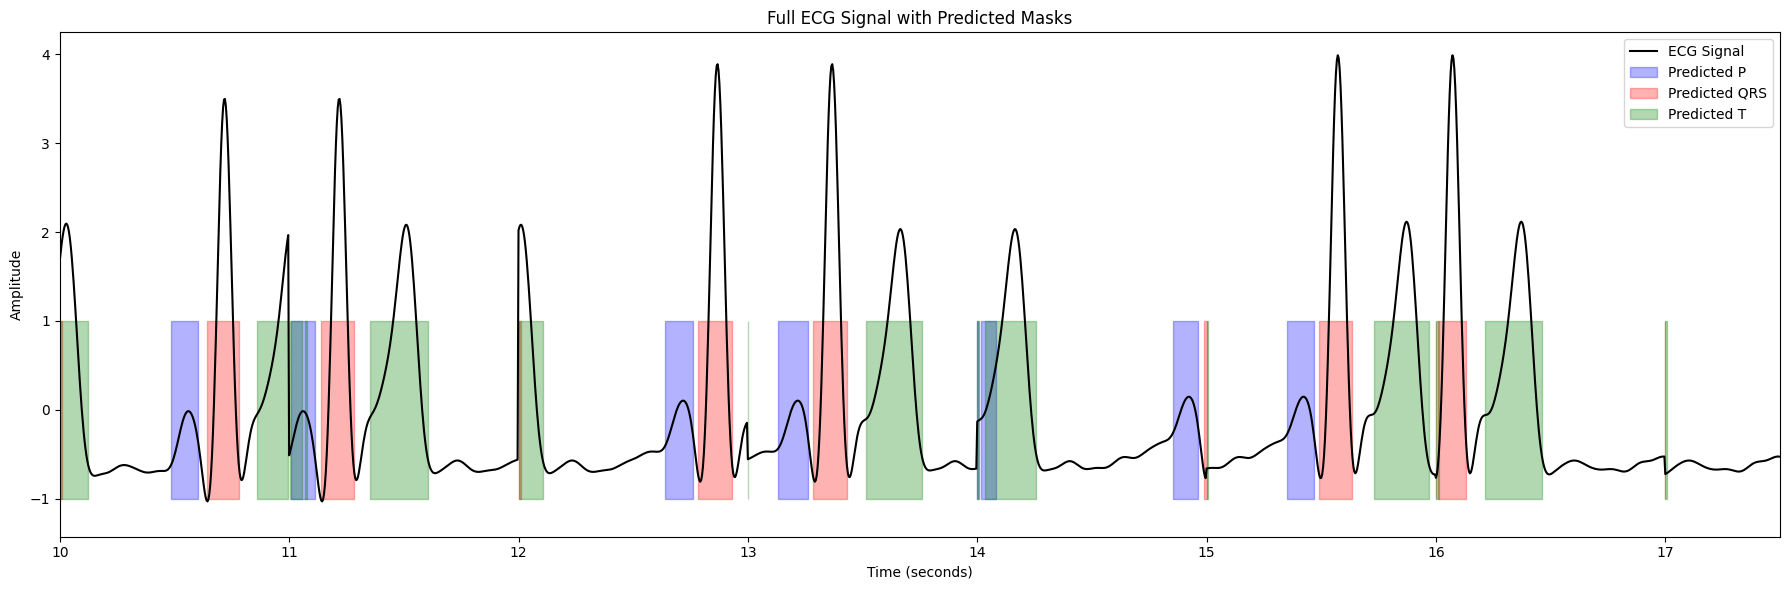

In [37]:
full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.xlim(10, 17.5)  # Zoom into 5s to 7s
plt.show()

# edb e0211

In [38]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/edb/1.0.0/e0211')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)


(2500,)


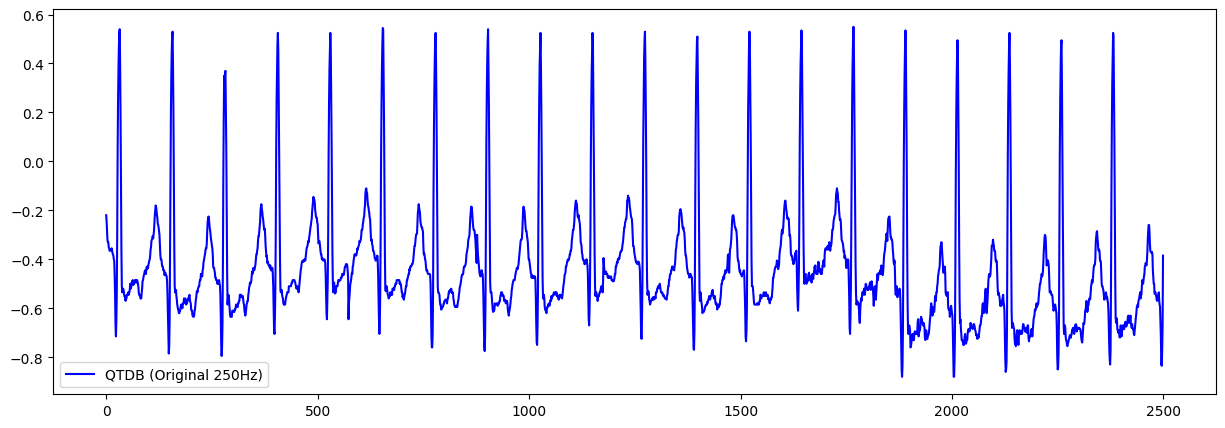

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(first_10_seconds, label=f"QTDB (Original {new_fs}Hz)", color='blue')
plt.legend()
plt.show()

In [40]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds,fs=new_fs)))
first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size , 250)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


In [41]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.1).astype(int)  # Convert probabilities to binary masks
#print(y_pred[y_pred > 0])  # P


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
[[[1.9368470e-01 1.3975932e-01 3.8276404e-01]
  [7.9993650e-02 2.3826662e-01 4.0031490e-01]
  [8.5175872e-02 1.1968737e-01 7.4555767e-01]
  ...
  [3.3390010e-03 3.9183680e-05 8.9249396e-01]
  [4.0313271e-03 2.4522094e-05 9.0543002e-01]
  [5.2562403e-03 1.2316719e-05 9.1951072e-01]]

 [[1.3342191e-01 2.1679710e-01 4.9123594e-01]
  [2.0229107e-01 6.1112493e-02 5.1621878e-01]
  [2.4833690e-01 5.5449042e-02 7.0683587e-01]
  ...
  [2.1879433e-03 2.8140799e-05 9.4596654e-01]
  [4.0377881e-03 1.6210879e-05 9.4337243e-01]
  [8.3243120e-03 1.9326806e-05 9.4855183e-01]]

 [[1.4830461e-01 1.8717471e-01 4.5063889e-01]
  [2.0714861e-01 6.2380616e-02 4.8008671e-01]
  [2.7308443e-01 5.5097688e-02 6.9421220e-01]
  ...
  [1.0071395e-02 7.9269257e-06 9.4838578e-01]
  [1.4526709e-02 9.6084013e-06 9.5045990e-01]
  [2.1889741e-02 1.4921681e-05 9.5834267e-01]]

 ...

 [[5.6474139e-03 2.1526605e-01 2.9351959e-01]
  [5.7637077e-03 1.9363335e-01 3.1720194e-01]
  [1.3005492

In [42]:
# Example:
y_pred_clean = post_process_predictions(y_pred, threshold=0.5, min_duration=int(0.03 * new_fs))  # ~30ms


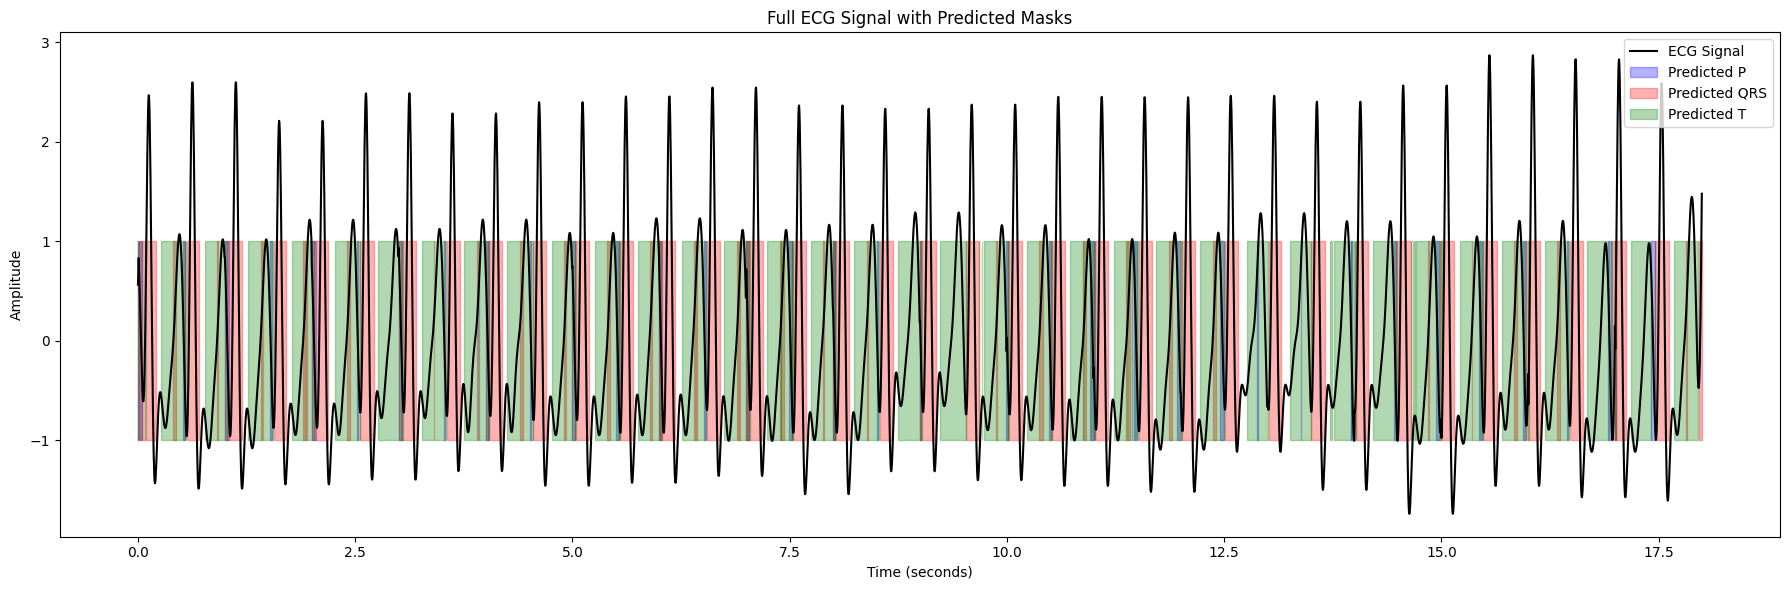

In [43]:
import matplotlib.pyplot as plt

full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

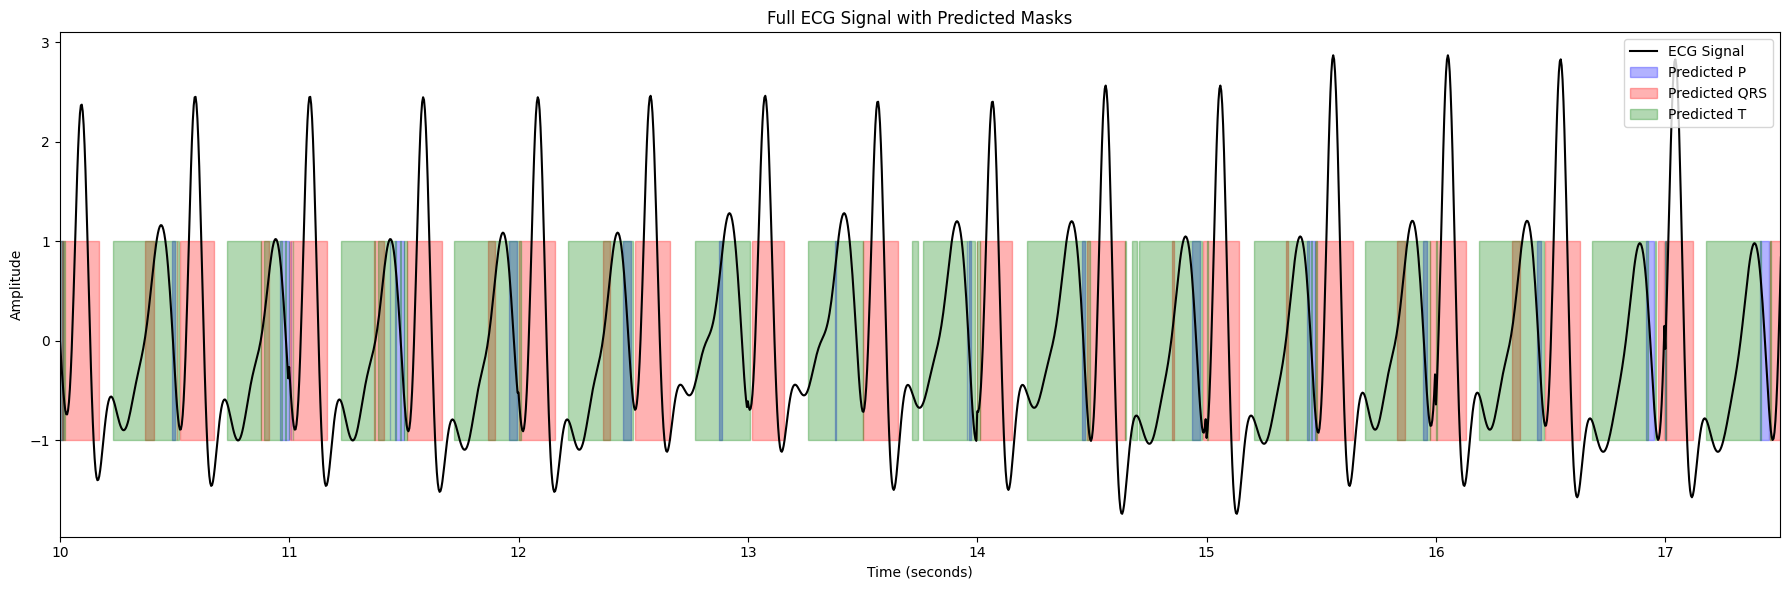

In [44]:
full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.xlim(10, 17.5)  # Zoom into 5s to 7s
plt.show()

# edb e1304

In [45]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/edb/1.0.0/e1304')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)


(2500,)


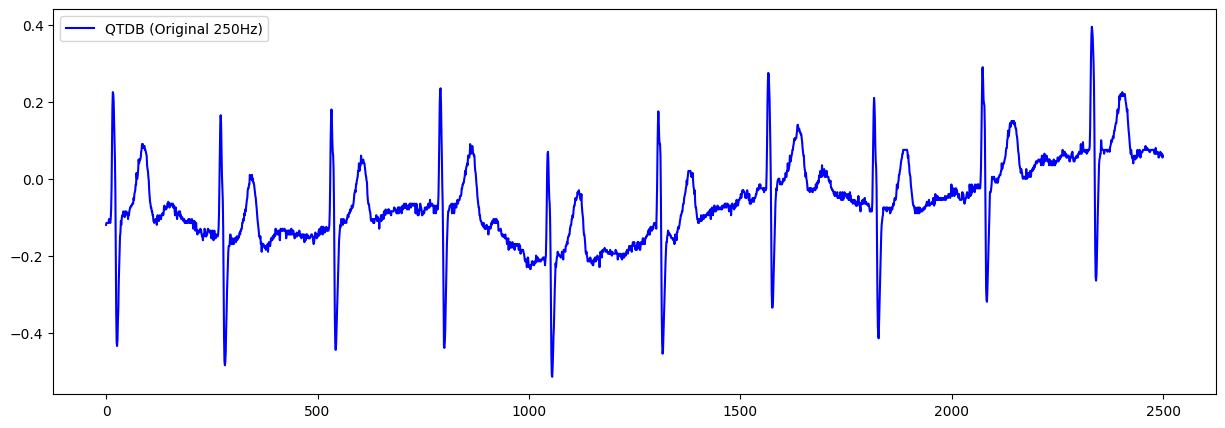

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(first_10_seconds, label=f"QTDB (Original {new_fs}Hz)", color='blue')
plt.legend()
plt.show()

In [47]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = normalize_signal(smooth_signal(bandpass_filter(first_10_seconds,fs=new_fs)))
first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
new_fs=250
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size , 250)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(18, 250, 1)


In [48]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.1).astype(int)  # Convert probabilities to binary masks
#print(y_pred[y_pred > 0])  # P


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
[[[9.62976075e-04 2.51448631e-01 3.42769563e-01]
  [3.10648320e-05 9.54408050e-01 3.53149958e-02]
  [4.48485753e-06 9.88234758e-01 3.51690012e-03]
  ...
  [6.86784312e-02 6.73662350e-02 1.57171453e-03]
  [8.83194059e-02 6.25740215e-02 1.91080873e-03]
  [8.82157013e-02 6.48420751e-02 1.15623779e-03]]

 [[1.09450929e-01 8.52112323e-02 1.10434800e-01]
  [1.11340135e-01 6.88632280e-02 1.54676169e-01]
  [3.30184013e-01 4.28371020e-02 2.42332578e-01]
  ...
  [2.41690502e-03 4.63985416e-05 7.87276626e-02]
  [1.20267586e-03 3.67011562e-05 6.36808127e-02]
  [1.00156828e-03 4.59046059e-05 5.07297590e-02]]

 [[7.69230127e-02 8.85298252e-02 9.06366408e-02]
  [5.32271117e-02 3.67362350e-02 6.03929795e-02]
  [6.25278354e-02 8.68371129e-02 1.79888606e-01]
  ...
  [6.98689759e-01 1.37546957e-02 1.41045183e-03]
  [7.70240247e-01 1.09532317e-02 1.52113556e-03]
  [7.85034895e-01 1.03146406e-02 1.36800180e-03]]

 ...

 [[8.90835896e-02 2.67199218e-01 5.15494525e-01]
 

In [49]:
# Example:
y_pred_clean = post_process_predictions(y_pred, threshold=0.5, min_duration=int(0.03 * new_fs))  # ~30ms


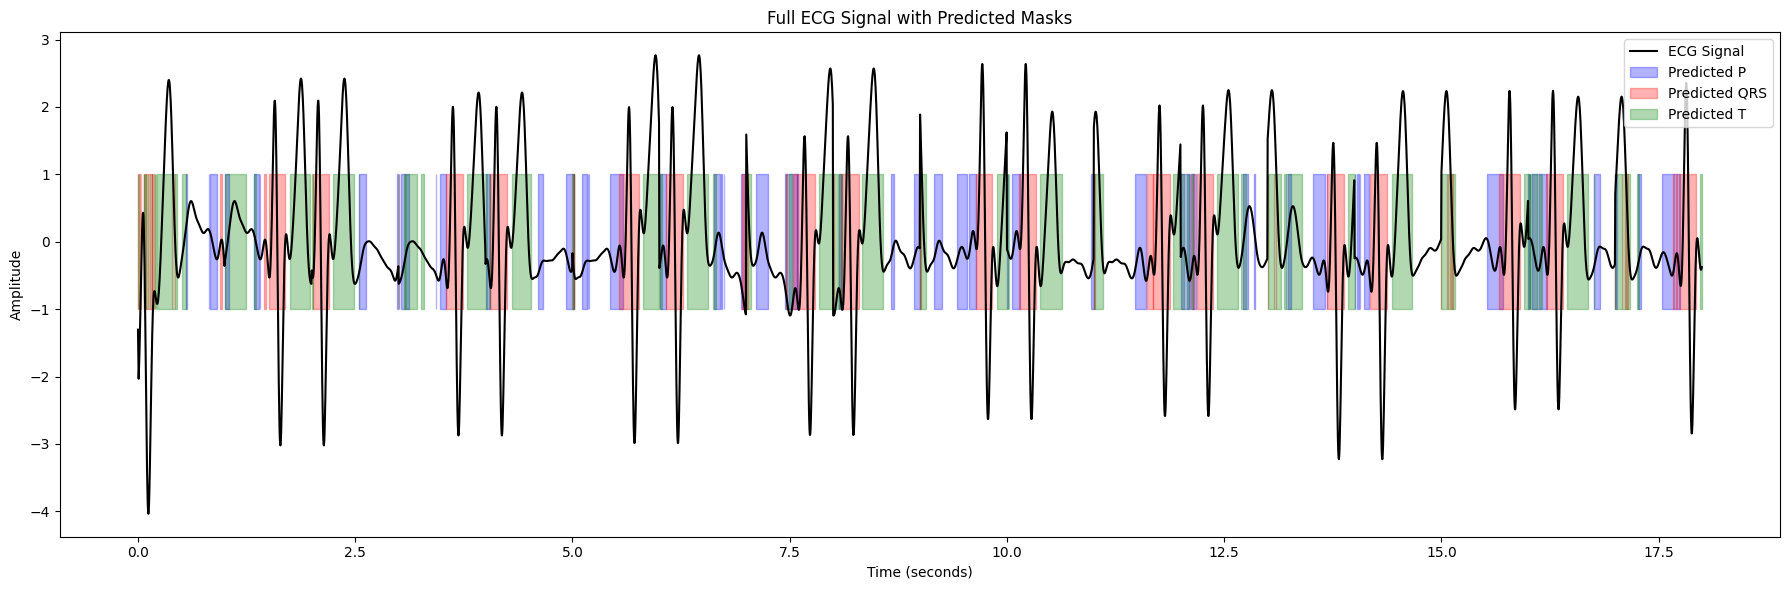

In [50]:
import matplotlib.pyplot as plt

full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

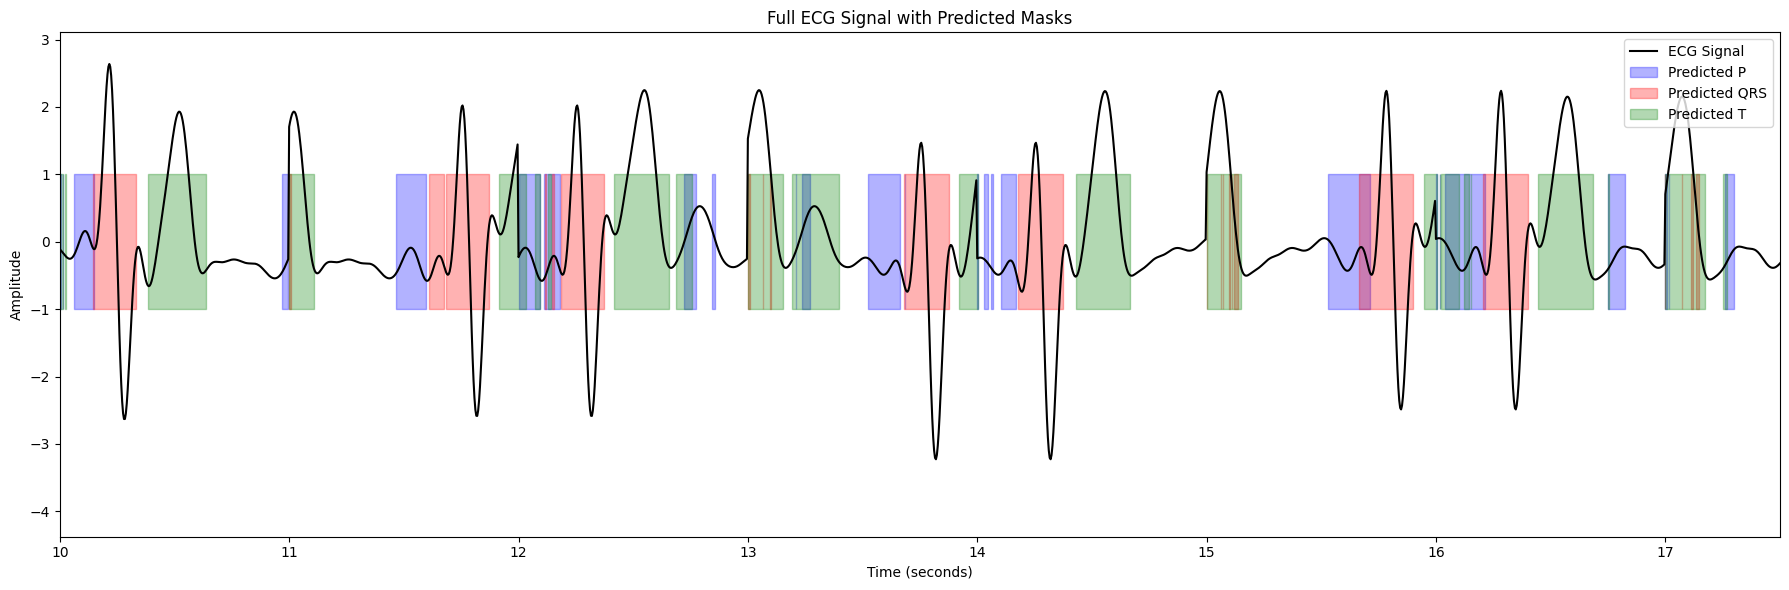

In [51]:
full_signal = new_segments.reshape(-1)  # shape: (num_segments * window_size,)
full_pred = y_pred.reshape(-1, 3)       # shape: (num_segments * window_size, 3)
time = np.arange(len(full_signal)) / 250  # Adjust for your fs

# === Step 2: Plot full signal with predicted masks
plt.figure(figsize=(18, 6))
plt.plot(time, full_signal, color='black', label='ECG Signal')

plt.fill_between(time, -1, 1, where=full_pred[:, 0] > 0.5, color='blue', alpha=0.3, label='Predicted P')
plt.fill_between(time, -1, 1, where=full_pred[:, 1] > 0.5, color='red', alpha=0.3, label='Predicted QRS')
plt.fill_between(time, -1, 1, where=full_pred[:, 2] > 0.5, color='green', alpha=0.3, label='Predicted T')

plt.title("Full ECG Signal with Predicted Masks")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()

plt.xlim(10, 17.5)  # Zoom into 5s to 7s
plt.show()